In [4]:
# Retrieving contact maps from PINDER

from pathlib import Path
from torch.utils.data import DataLoader
from pinder.core import PinderLoader
from pinder.core.index.system import PinderSystem
from pinder.core.loader import structure
from pinder.core import get_pinder_location
from torch_geometric.nn import radius as georadius
from tqdm import tqdm
from pinder.core.loader import filters
from biotite.structure import sasa, apply_residue_wise
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import os
import random
import pandas as pd
import torch
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, average_precision_score
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt

PINDER_BASE_DIR="/scicore/home/schwede/durair0000/.local/share/"
os.environ["PINDER_BASE_DIR"] = PINDER_BASE_DIR
get_pinder_location()

def get_data(
    system_id,
    interface_threshold=8.0,
):
    system = PinderSystem(system_id)
    if system is None:
        return None
    seq_r, seq_l = system.native_R.sequence, system.native_L.sequence
    try:
        sasa_r = apply_residue_wise(
            system.native_R.atom_array, sasa(system.native_R.atom_array), np.nansum
        )
        sasa_l = apply_residue_wise(
            system.native_L.atom_array, sasa(system.native_L.atom_array), np.nansum
        )
    except Exception as e:
        print(e)
        return None
    r_coords = system.native_R.filter("atom_name", mask=["CA"]).coords
    l_coords = system.native_L.filter("atom_name", mask=["CA"]).coords
    if r_coords.shape[0] == len(seq_r) and l_coords.shape[0] == len(seq_l):
        pos_l, pos_r = georadius(
            torch.tensor(r_coords),
            torch.tensor(l_coords),
            r=interface_threshold,
            max_num_neighbors=10000,
        )
        return {
            "id": system_id,
            "pos_r": pos_r,
            "pos_l": pos_l,
            "seq_r": seq_r,
            "seq_l": seq_l,
            "sasa_r": sasa_r,
            "sasa_l": sasa_l,
        }
    return None

def get_atom_data(split, interface_threshold=8.0):
    # Retrieving positions of the residues that are considered to be interacting with each other
    df = pd.read_csv(f"{SPLITS_DIR}/{split}.txt", sep="\t")
    
    ids = {"R": [], "L": []}
    for i, j in df.iterrows():
        # Neglecting negatives
        if(df["label"][i] == 0): continue
        idR = df["protein1"][i]
        idL = df["protein2"][i]
        ids["R"].append(idR)
        ids["L"].append(idL)

    atom_data = []
    
    for i, id_ in enumerate(ids["R"]):
        try:
            struct_r = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{id_}-R.pdb", pinder_id=id_)
            struct_l = structure.Structure(f"{PINDER_BASE_DIR}/pinder/2024-02/pdbs/{ids['L'][i]}-L.pdb", pinder_id=ids['L'][i])
            
            r_coords = struct_r.filter("atom_name", mask=["CA"]).coords
            l_coords = struct_l.filter("atom_name", mask=["CA"]).coords

            if(len(r_coords) != len(struct_r.sequence)):
                raise Exception(f"Number of coordinates does not match the length of sequence {id_}-R") 
            if(len(l_coords) != len(struct_l.sequence)):
                raise Exception(f"Number of coordinates does not match the length of sequence {ids['L'][i]}-L") 
        except Exception as e:
            print(e)
            continue

        sasa_r = apply_residue_wise(
            struct_r.atom_array, sasa(struct_r.atom_array), np.nansum
        )
        sasa_l = apply_residue_wise(
            struct_l.atom_array, sasa(struct_l.atom_array), np.nansum
        )
        
        dist_m = torch.cdist(torch.tensor(r_coords), torch.tensor(l_coords))

        pos_l, pos_r = georadius(
            torch.tensor(r_coords),
            torch.tensor(l_coords),
            r=interface_threshold,
            max_num_neighbors=10000,
        )

        pos_dists = []
        for j in range(len(pos_r)):
            pos_dists.append(dist_m[pos_r[j]][pos_l[j]].item())
        
        atom_data_el = {
            "id": f"{id_}-{ids['L'][i]}",
            "pos_r": pos_r,
            "pos_l": pos_l,
            "sasa_r": sasa_r,
            "sasa_l": sasa_l,
            "len_r": len(struct_r.sequence),
            "len_l": len(struct_l.sequence),
            "dist_matrix": dist_m,
            "pos_dists": pos_dists,
            "num_r_coords": len(r_coords),
            "num_l_coords": len(l_coords)
        }
        
        atom_data.append(atom_data_el)

    return atom_data

def get_contact_map(data_dict, padding=None):
    contact_map = np.zeros((data_dict["len_r"], data_dict["len_l"]))

    for i in range(len(data_dict["pos_r"])):
        contact_map[data_dict["pos_r"][i].item()][data_dict["pos_l"][i].item()] = 1

    if(padding):
        contact_map = contact_map[padding:-padding, padding:-padding]
    return contact_map

def get_cj_map(data_dict, cj_path, n, padding=None, biolm="gLM2"):
    id_for_file = data_dict["id"].translate(str.maketrans({'_': '-', '-': '_'}))
    cj = np.load(f"{cj_path}/{id_for_file}_fastCJ.npy")
    
    # Setting the threshold for the outlier count
    m = np.mean(cj)
    s = np.std(cj)
    threshold = m+n*s

    # Retrieving upper-right quadrant and skipping the tokens <+>
    if(biolm == "glm2"):
        upper_right_quadrant_cj = cj[1:data_dict["len_r"]+1, data_dict["len_r"]+2:]
        upper_right_quadrant_cm = np.where(upper_right_quadrant_cj > threshold, 1, 0)
    elif(biolm == "mint"):
        upper_right_quadrant_cj = cj[1:data_dict["len_r"]+1, data_dict["len_r"]+3:-1]
        upper_right_quadrant_cm = np.where(upper_right_quadrant_cj > threshold, 1, 0)
    
    if(padding):
        upper_right_quadrant_cj = upper_right_quadrant_cj[padding:-padding, padding:-padding]

    return upper_right_quadrant_cm, upper_right_quadrant_cj

def get_metrics_and_distances(data, cj_path, biolm="glm2", get_distances=True, n=3):
    mccs = []
    precs = []
    recs = []
    bal_accs = []
    tnrs = []
    pr_aucs = []
    
    perc_cj_bits_in_cm_arr = []
    
    dist_corr = []
    neg_dists = []
    pos_dists = []
    
    for i in range(len(data)):
        contact_map = get_contact_map(data[i], padding=None)
        cj_contact_map, cj = get_cj_map(data[i], cj_path, n=n, padding=None, biolm=biolm)
        
        # Compute the correlation between the quadrants
        mcc = matthews_corrcoef(contact_map.flatten(), cj_contact_map.flatten())
        prec = precision_score(contact_map.flatten(), cj_contact_map.flatten(), zero_division=0.0)
        rec = recall_score(contact_map.flatten(), cj_contact_map.flatten())
        pr_auc = average_precision_score(contact_map.flatten(), cj.flatten())
        bal_acc = balanced_accuracy_score(contact_map.flatten(), cj_contact_map.flatten())
        tn, fp, fn, tp = confusion_matrix(contact_map.flatten(), cj_contact_map.flatten()).ravel()
        tnr = tn/(tn+fp)
        
        mccs.append(mcc)
        precs.append(prec)
        recs.append(rec)
        pr_aucs.append(pr_auc)
        bal_accs.append(bal_acc)
        tnrs.append(tnr)
    
        # Computing the percentage of cj_cm signals in true_cm
        cj_bits_in_cm = np.where(cj_contact_map == 1, contact_map, 0)
        if(np.sum(cj_contact_map)):
            perc_cj_bits_in_cm = cj_bits_in_cm.sum()/np.sum(cj_contact_map)
        else:
            perc_cj_bits_in_cm = 0
        perc_cj_bits_in_cm_arr.append(perc_cj_bits_in_cm)
    
        # Computing correlation between distances and cj signals
        dist_corr.append(spearmanr(np.asarray(data[i]["dist_matrix"].flatten()), cj.flatten()).statistic)

        if(get_distances):
            # Collecting info for plotting the distribution of distances
            bool_pos_mask = cj_contact_map.astype(bool)
            bool_neg_mask = (1-cj_contact_map).astype(bool)
            
            pos_dist = data[i]["dist_matrix"][bool_pos_mask]
            neg_dist = np.asarray(data[i]["dist_matrix"][bool_neg_mask])
            
            neg_dist_downsampled = random.sample(sorted(neg_dist), len(pos_dist))
        
            pos_dists += pos_dist
            neg_dists += neg_dist_downsampled
        else:
            # Collecting info for plotting the distribution of CJ signals
            bool_pos_mask = contact_map.astype(bool)
            bool_neg_mask = (1-contact_map).astype(bool)
            
            pos_dist = torch.tensor(cj[bool_pos_mask])
            neg_dist = cj[bool_neg_mask]
            
            neg_dist_downsampled = random.sample(sorted(neg_dist), len(pos_dist))
        
            pos_dists += pos_dist
            neg_dists += neg_dist_downsampled
        

    avg_metrics = {
        'mcc': np.average(mccs),
        'precision': np.average(precs),
        'recall': np.average(recs),
        'pr_auc': np.average(pr_aucs),
        'balanced_accuracy': np.average(bal_accs),
        'specificity': np.average(tnrs),
        'outlier_percentage_in_contact_map': np.average(perc_cj_bits_in_cm_arr),
    }

    distances = {
        'dist_cj_correlation_coeffs': dist_corr,
        'positive_pair_dist': pos_dists,
        'negative_pair_dist': neg_dists
    }

    return avg_metrics, distances

def present_metrics(avg_metrics):
    print("MCC: ", avg_metrics['mcc'])

    # Ability not to label a negative sample as a positive
    print("Precision: ", avg_metrics['precision'])
    
    # Ability to find all positive samples 
    print("Recall: ", avg_metrics['recall'])

    # PR AUC of CJ signals for interacting and non-interacting residues
    print("PR AUC: ", avg_metrics['pr_auc'])
    
    # Ability to find all negative samples
    print("Specificity: ", avg_metrics['specificity'])
    
    # Being right overall
    print("Balanced accuracy: ", avg_metrics['balanced_accuracy'])
    
    # How many matches of outliers in the contact map signal
    print("Average percentage of outliers within contact map: ", avg_metrics['outlier_percentage_in_contact_map'])

def plot_distance_distribution(dist_info):
    # Correlation coefficient between real distances and CJ signals
    print("Correlation between distances and CJ: ", np.average(dist_info['dist_cj_correlation_coeffs']))
    
    dist_corr = np.array(dist_info['dist_cj_correlation_coeffs'])
    
    print("Average corr. coeff. for negative corr. coeff: ", np.average(dist_corr[np.where(dist_corr < 0)]))
    print("Average corr. coeff. for positive corr. coeff: ", np.average(dist_corr[np.where(dist_corr >= 0)]))
    
    # Plotting distribution of distances for positive and negative pairs of residues.
    # Positivity / negativity is determined based on the signals in categorical Jacobian.
    # If the signal is considered as an outlier, it indicated the "positive" pair.
    
    pos_dists = dist_info['positive_pair_dist']
    neg_dists = dist_info['negative_pair_dist']
    
    matplotlib.rcParams['figure.dpi'] = 300
    plt.rcParams['font.size'] = 16
    plt.figure(figsize=(10, 5))
    
    plt.hist(pos_dists, bins=range(0, round(max(pos_dists).item())+8, 8),
             color='red', alpha=0.5, label='positive'
    )
    plt.hist(neg_dists, bins=range(0, round(max(pos_dists).item())+8, 8),
             color='blue', alpha=0.5, label='negative'
    )
    plt.xlabel('distance')
    plt.ylabel('frequency')
    plt.title('Distance distribution of positive and negative pairs of residues')
    plt.legend()
    
    plt.xticks(range(0, round(max(pos_dists).item())+8, 8))
    plt.show()

def plot_signal_distribution(dist_info, step=0.25):    
    # Plotting distribution of distances for positive and negative pairs of residues.
    # Positivity / negativity is determined based on the distance (8 A) threshold between residues in protein complex.
    # If the signal is considered as an outlier, it indicated the "positive" pair.
    
    pos_dists = dist_info['positive_pair_dist']
    neg_dists = dist_info['negative_pair_dist']
    
    matplotlib.rcParams['figure.dpi'] = 300
    plt.rcParams['font.size'] = 16
    plt.figure(figsize=(10, 5))
    
    plt.hist(pos_dists, bins=np.arange(round(min(pos_dists).item()), round(max(pos_dists).item())+step, step),
             color='red', alpha=0.5, label='interacting'
    )
    plt.hist(neg_dists, bins=np.arange(round(min(pos_dists).item()), round(max(pos_dists).item())+step, step),
             color='blue', alpha=0.5, label='non-interacting'
    )
    plt.xlabel('categorical Jacobian value')
    plt.ylabel('frequency')
    plt.title('Distribution of CJ values of interacting and non-interacting pairs of residues')
    plt.legend()
    
    #plt.xticks(range(0, round(max(pos_dists).item())+8, 8))
    plt.show()

In [2]:
SPLITS_DIR="/scicore/home/schwede/pudziu0000/projects/gLM/data/PINDER/eubacteria_5_1024_512_species_heterodimers_leak_free/"
data = get_atom_data("test")
len(data)

53

MCC:  0.013490212992137375
Precision:  0.024834054481936294
Recall:  0.01636828345630516
PR AUC:  0.010796353298615868
Specificity:  0.9963203198011303
Balanced accuracy:  0.5063443016287178
Average percentage of outliers within contact map:  0.024834054481936294
Correlation between distances and CJ:  -0.05879112506127872
Average corr. coeff. for negative corr. coeff:  -0.12119818946914371
Average corr. coeff. for positive corr. coeff:  0.062555944620681


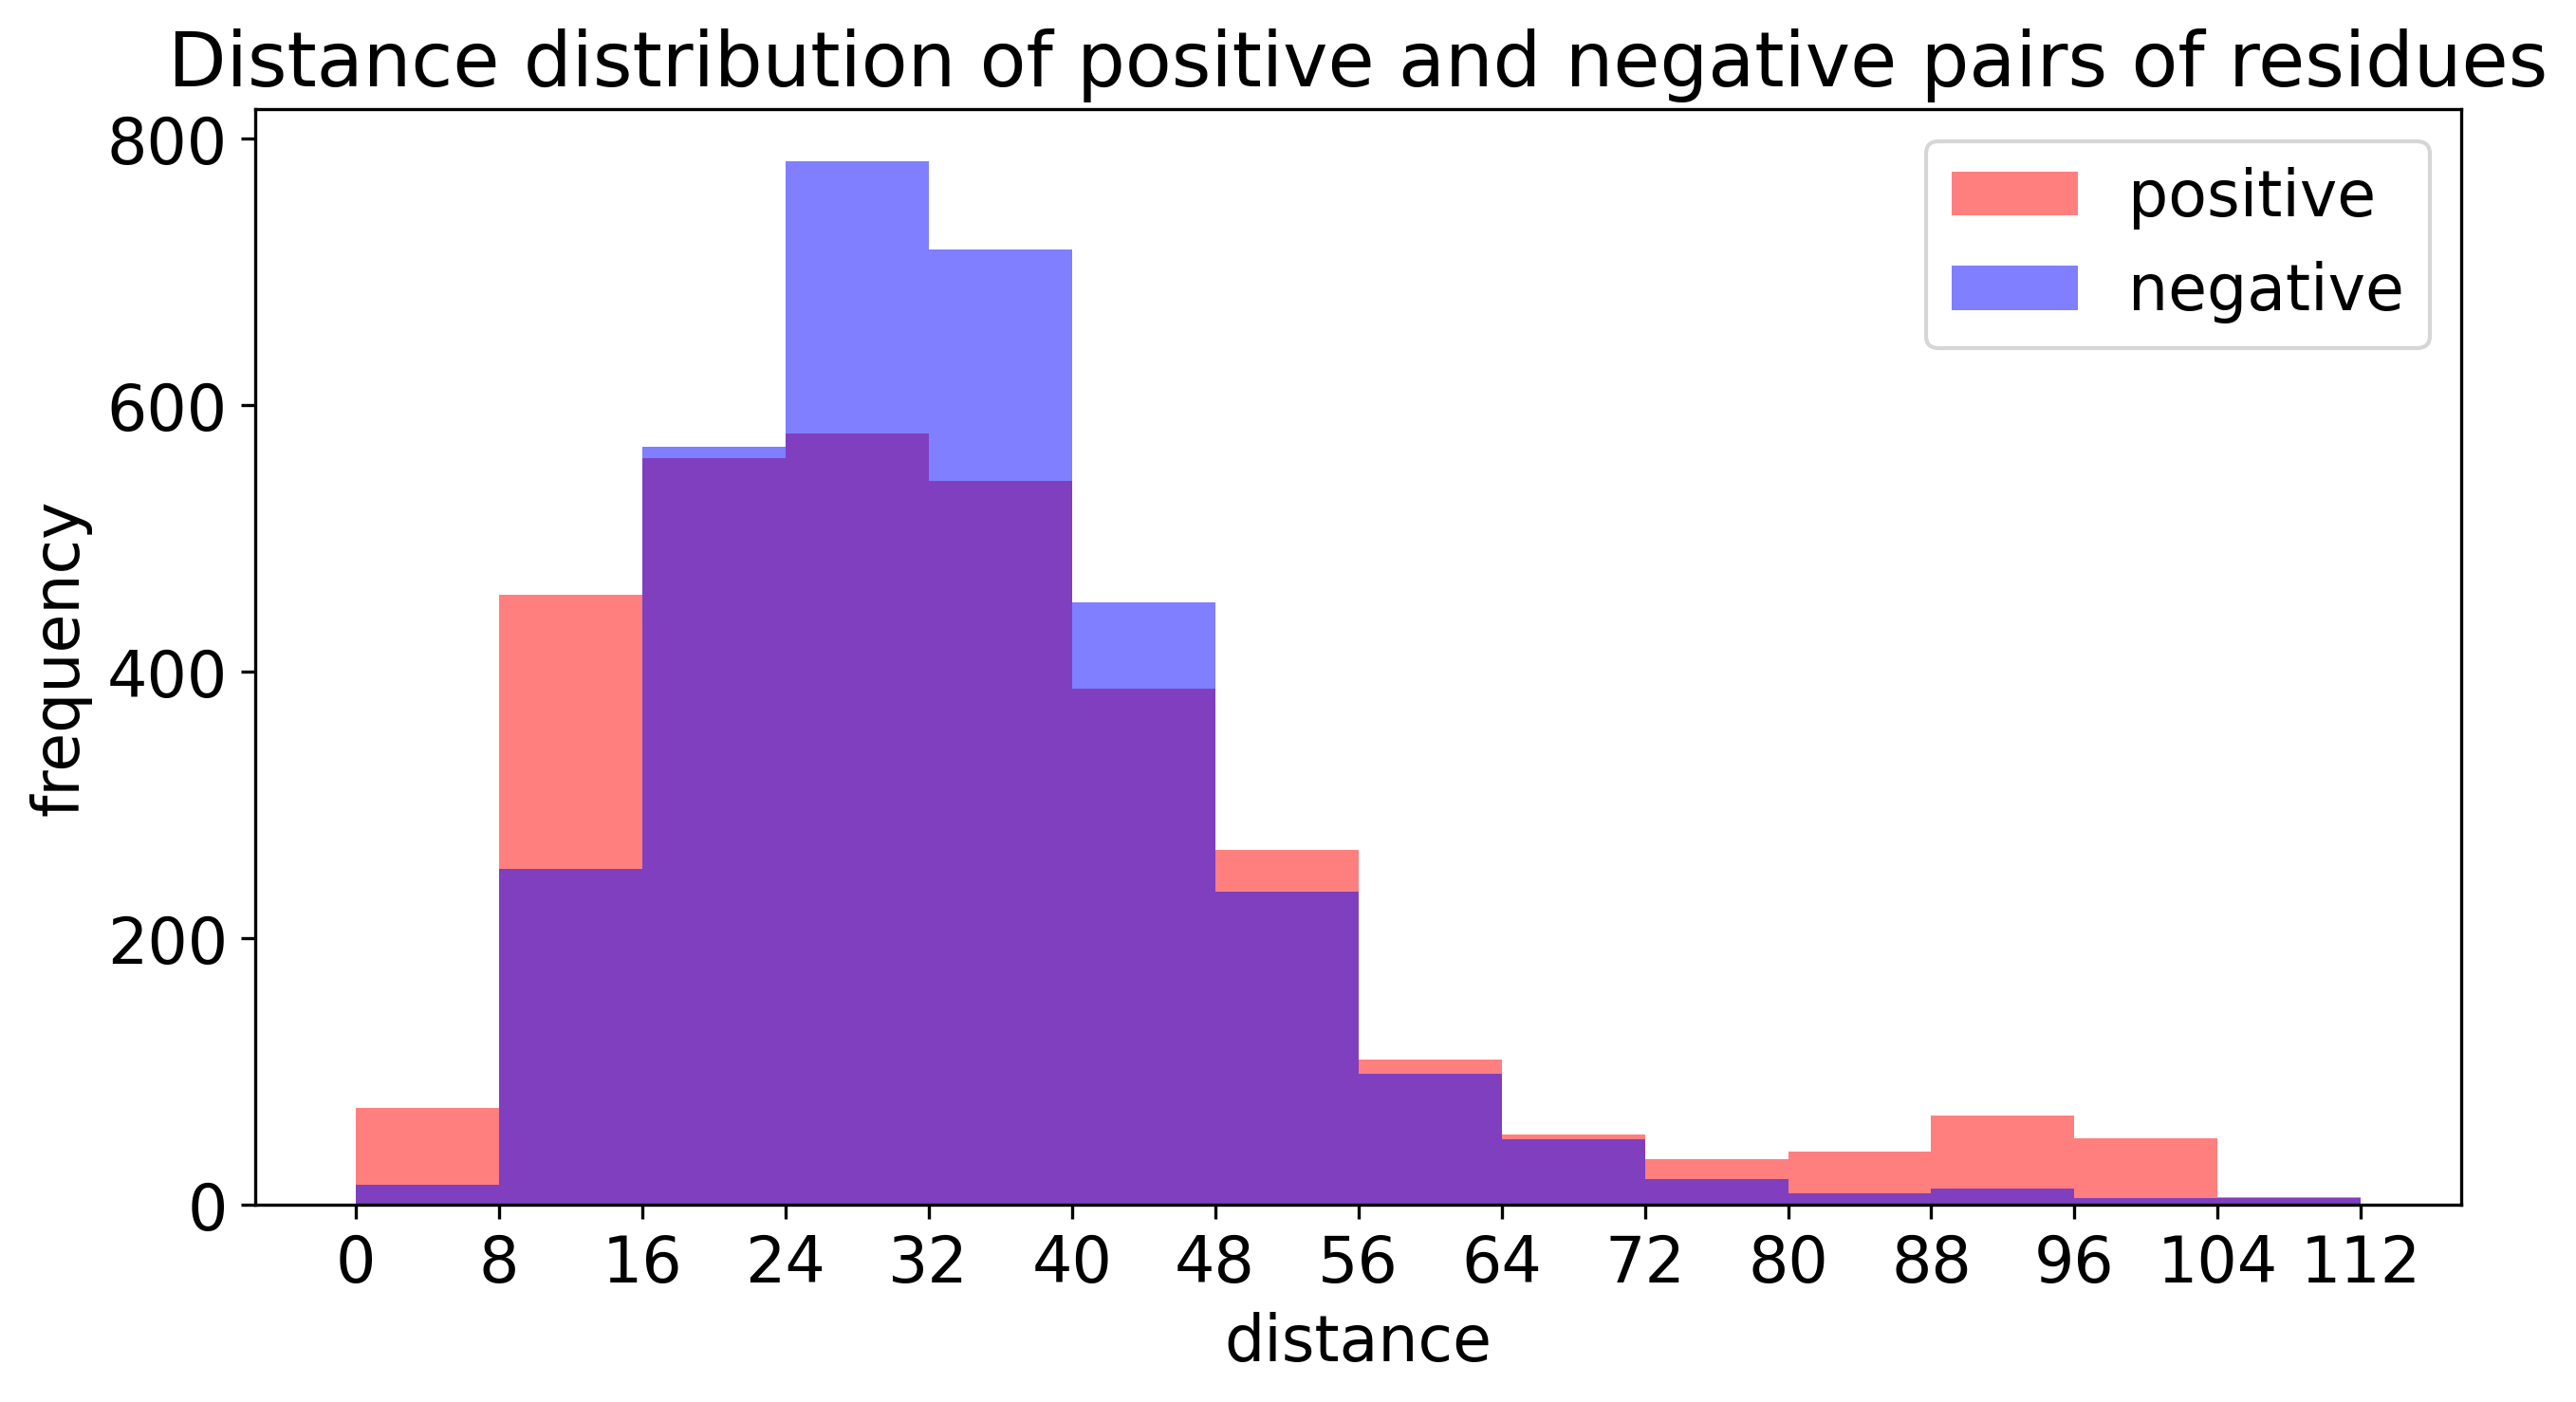

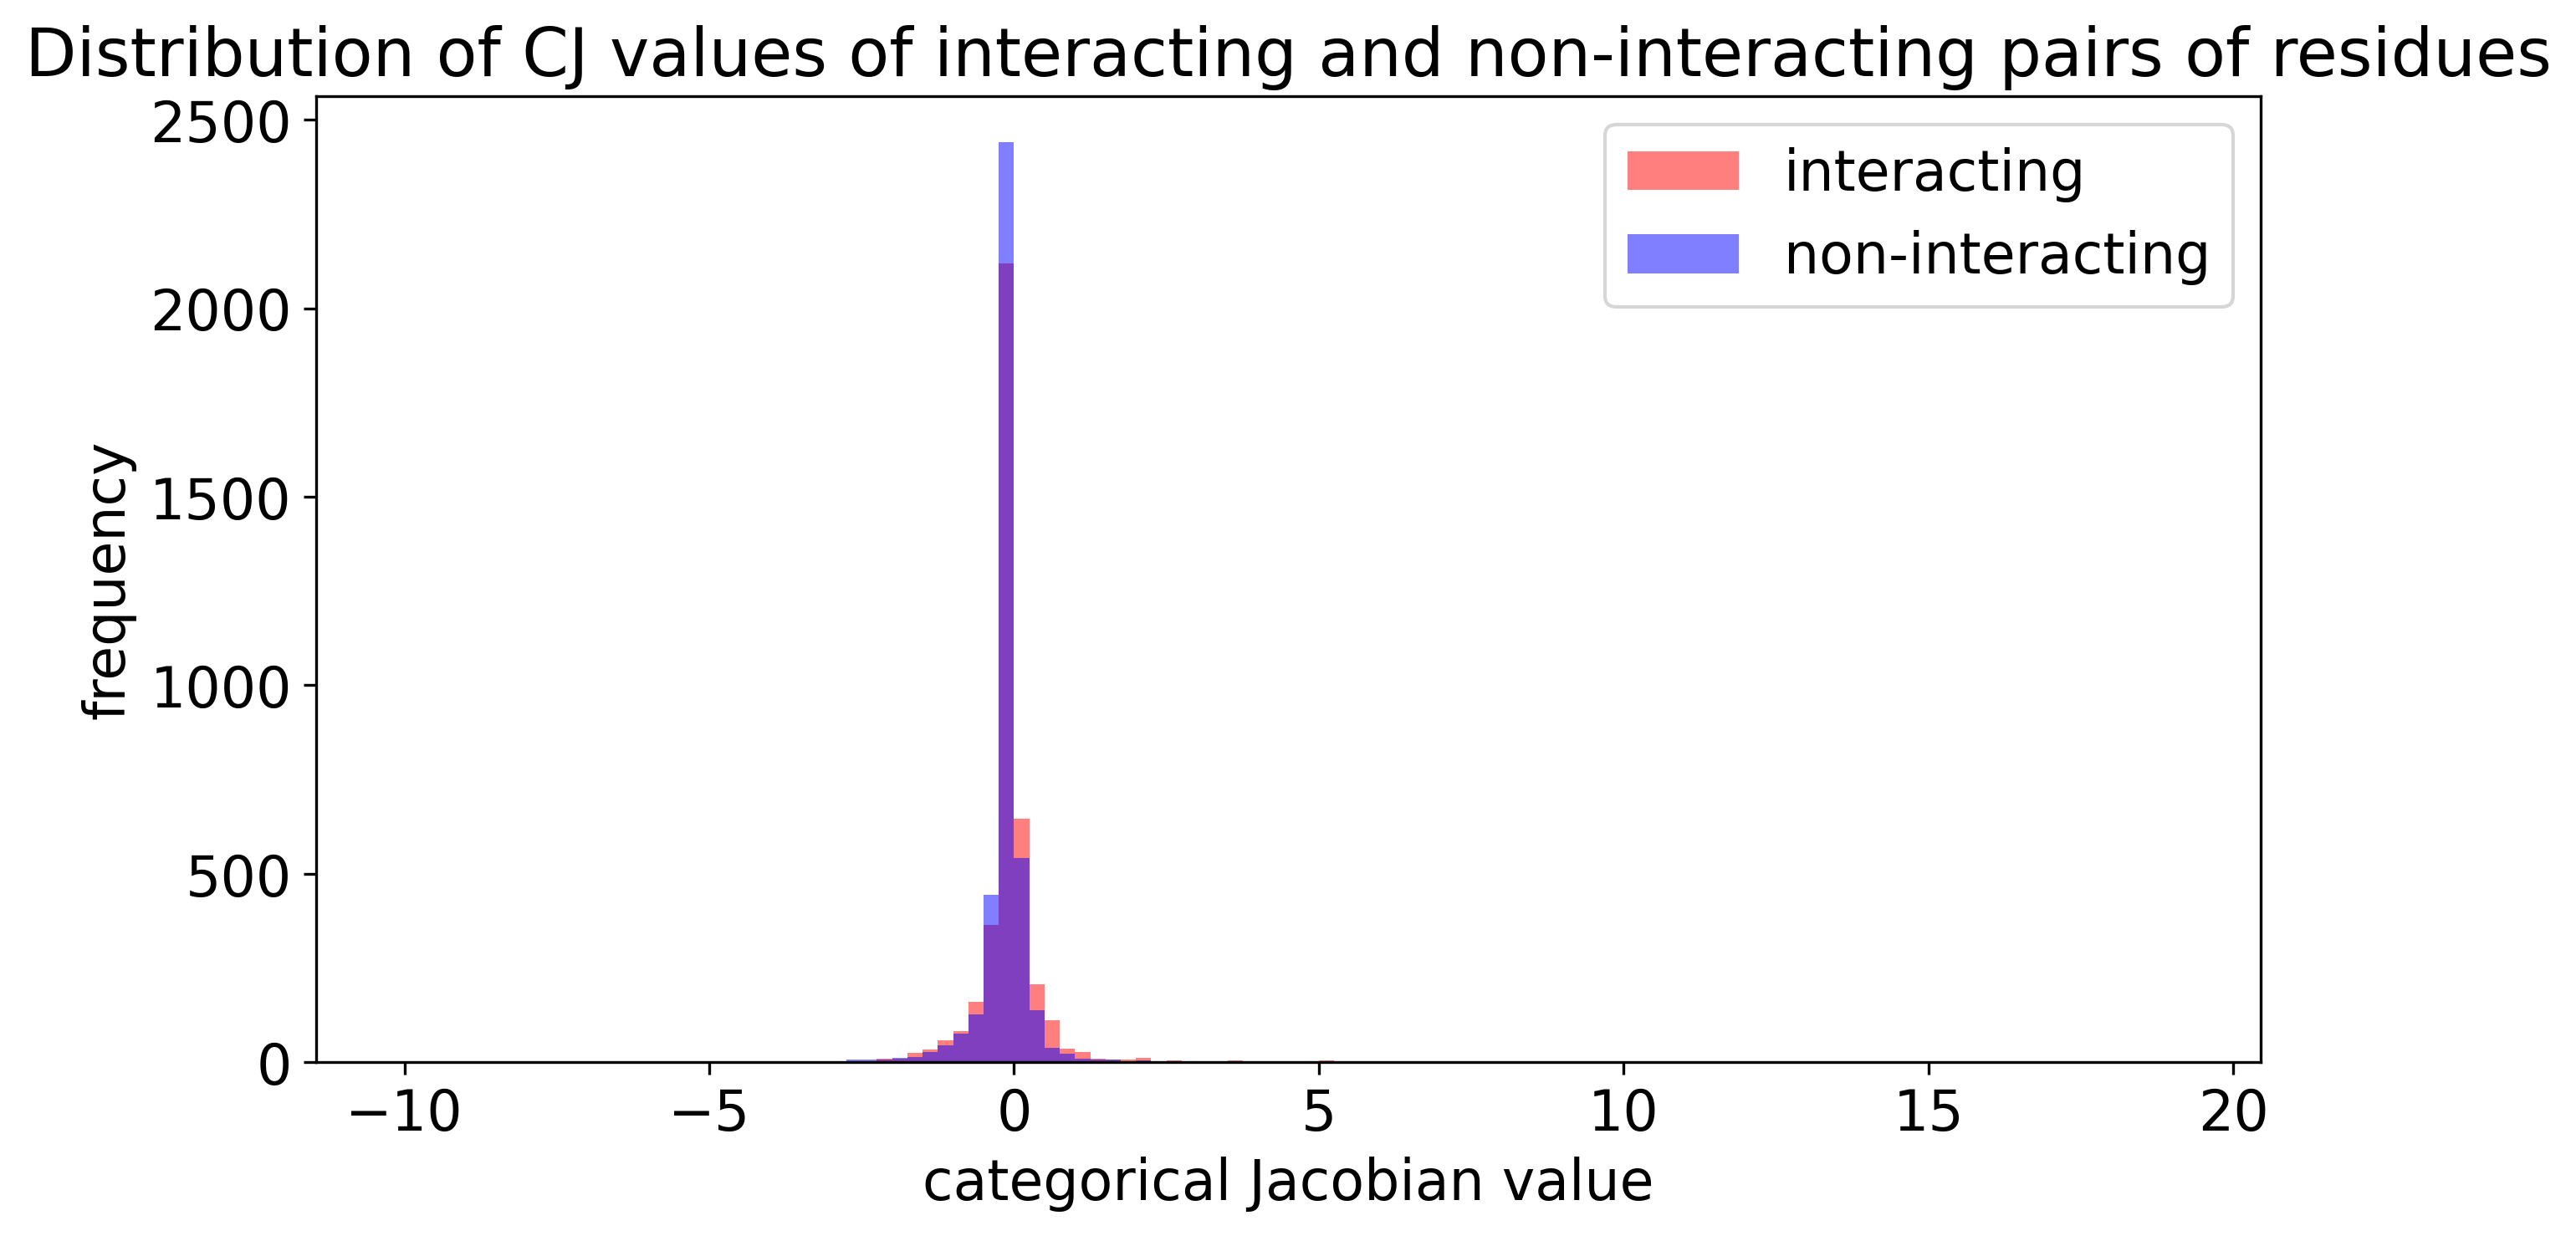

In [3]:
# Loading the categorical Jacobian
CJ_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/glm2_Euclidean/"

avg_metrics, dist_info = get_metrics_and_distances(data, CJ_PATH, get_distances=True)
present_metrics(avg_metrics)
plot_distance_distribution(dist_info)

_, signal_info = get_metrics_and_distances(data, CJ_PATH, get_distances=False)
plot_signal_distribution(signal_info, step=0.25)

MCC:  0.005371703900322439
Precision:  0.00984521698905168
Recall:  0.0068893370104104144
PR AUC:  0.008241611880821276
Specificity:  0.9982783903832882
Balanced accuracy:  0.5025838636968493
Average percentage of outliers within contact map:  0.00984521698905168
Correlation between distances and CJ:  -0.0323025237182244
Average corr. coeff. for negative corr. coeff:  -0.1035350088204499
Average corr. coeff. for positive corr. coeff:  0.06807052347127512


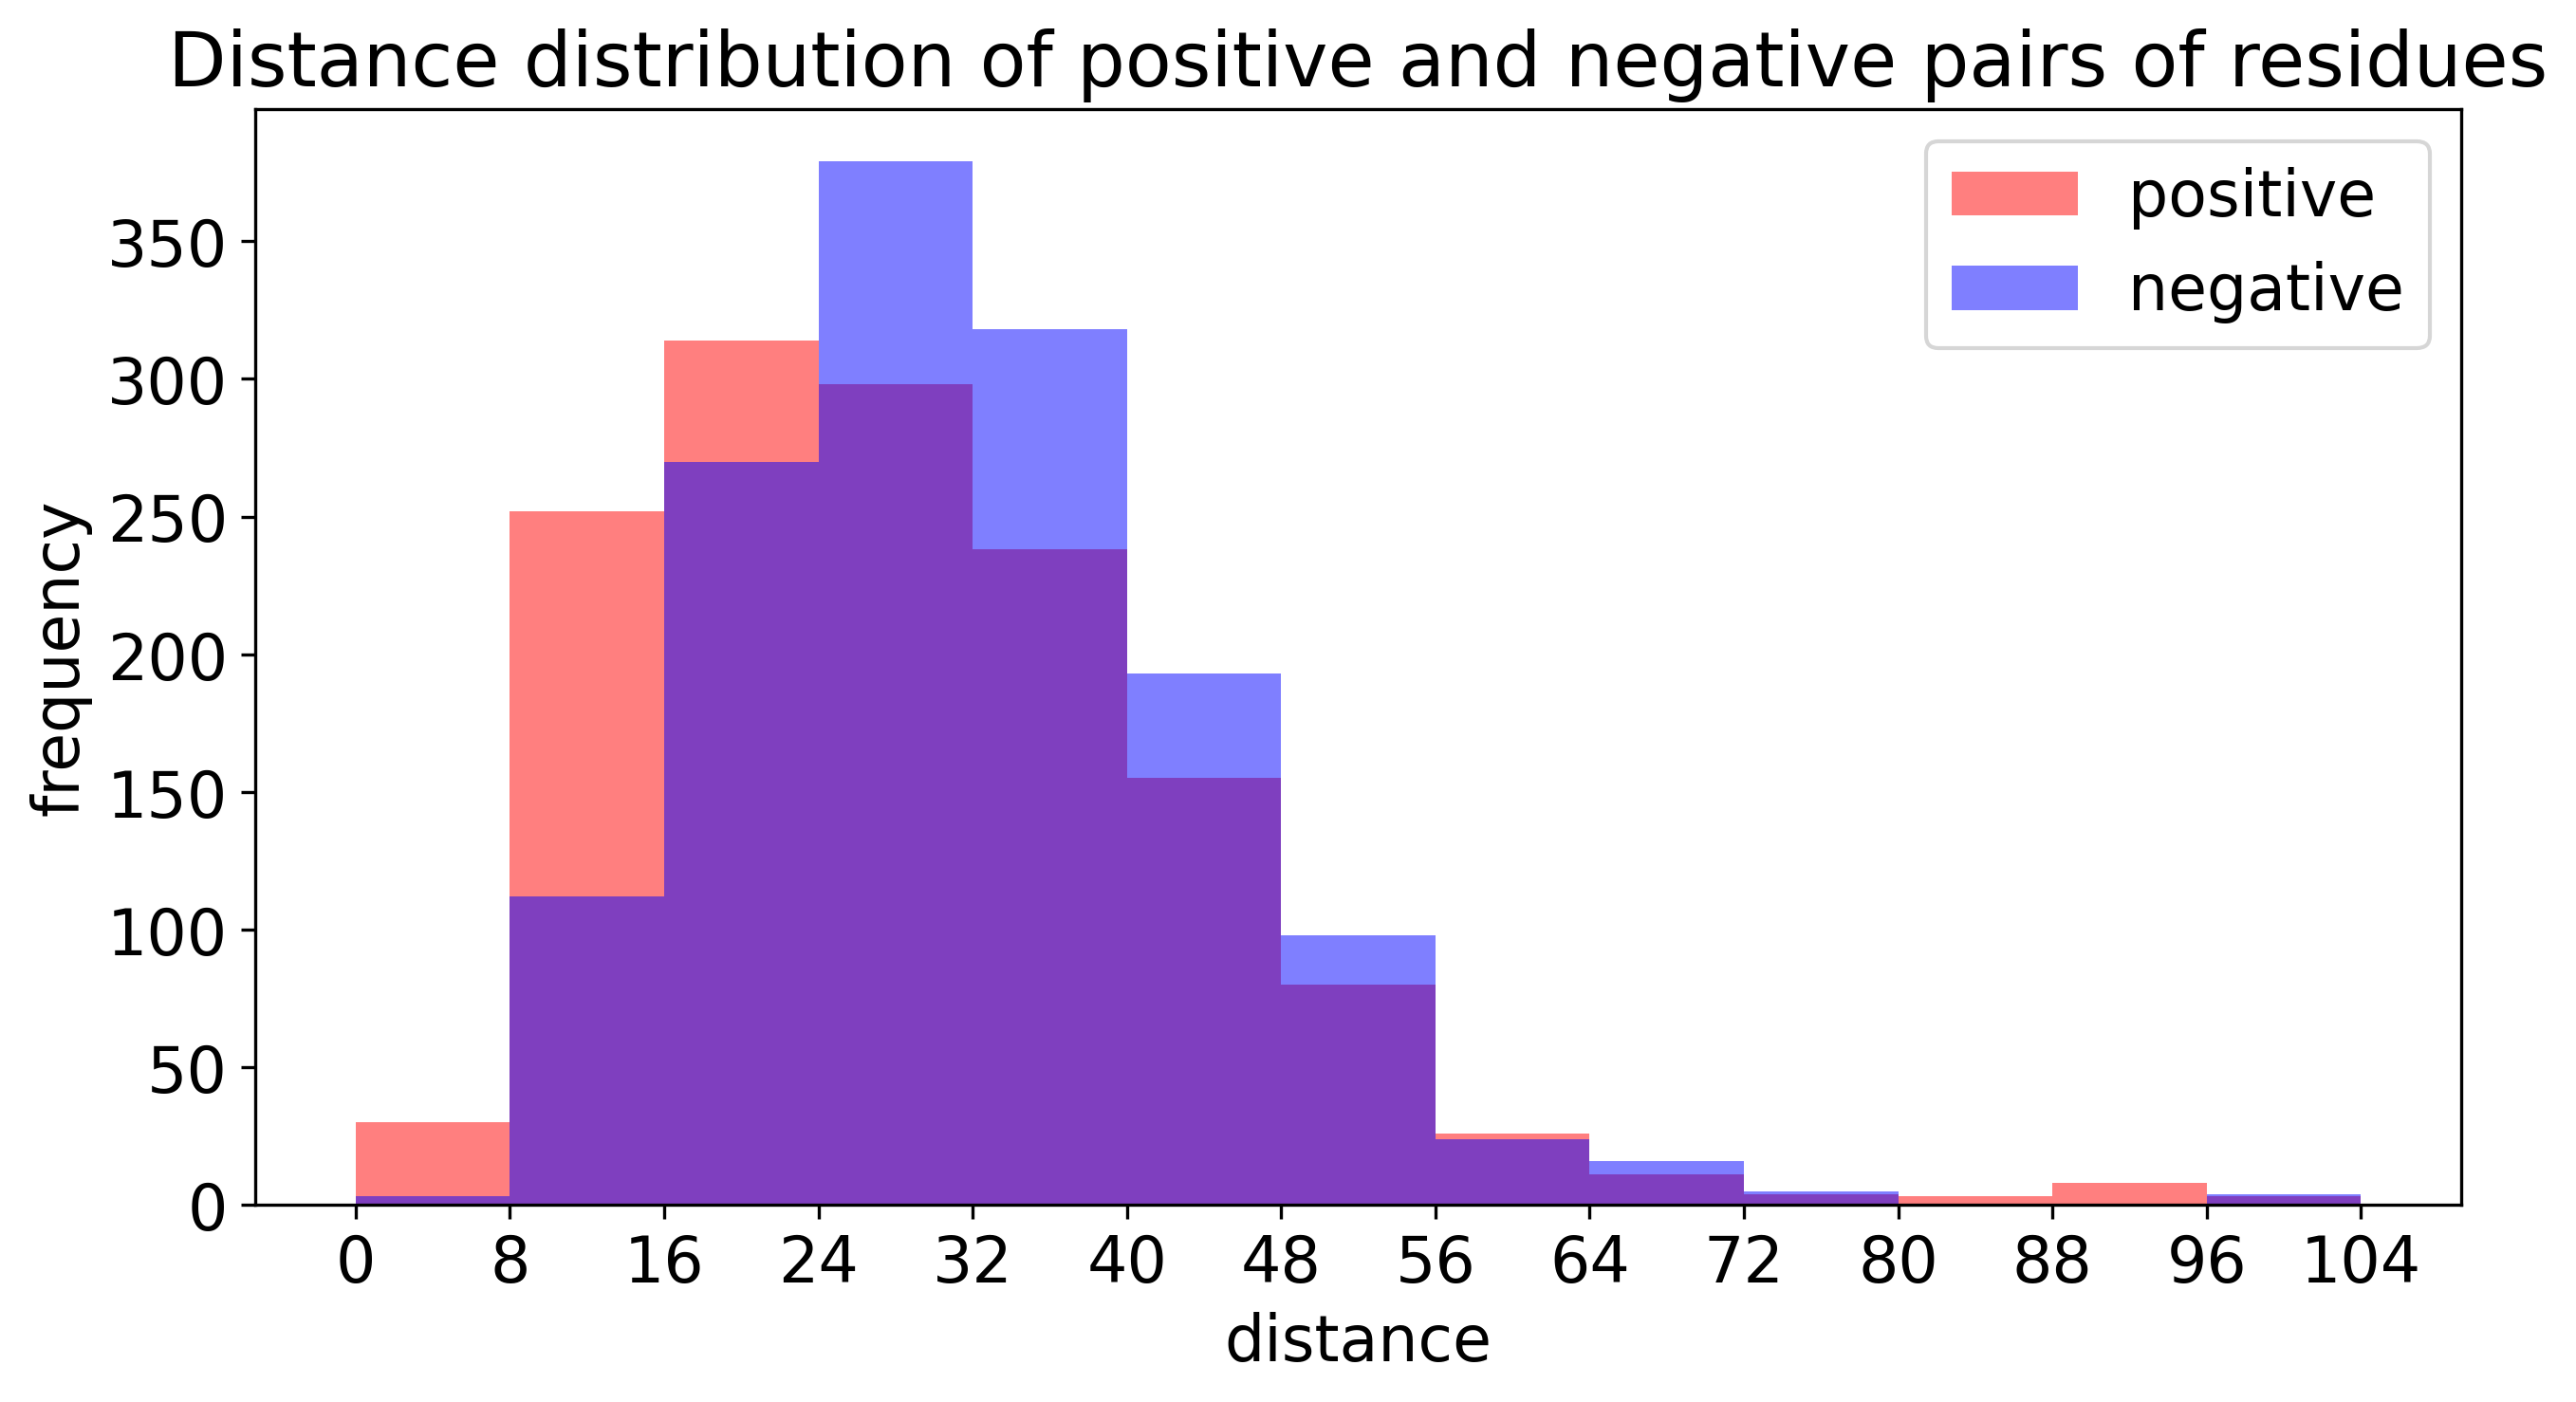

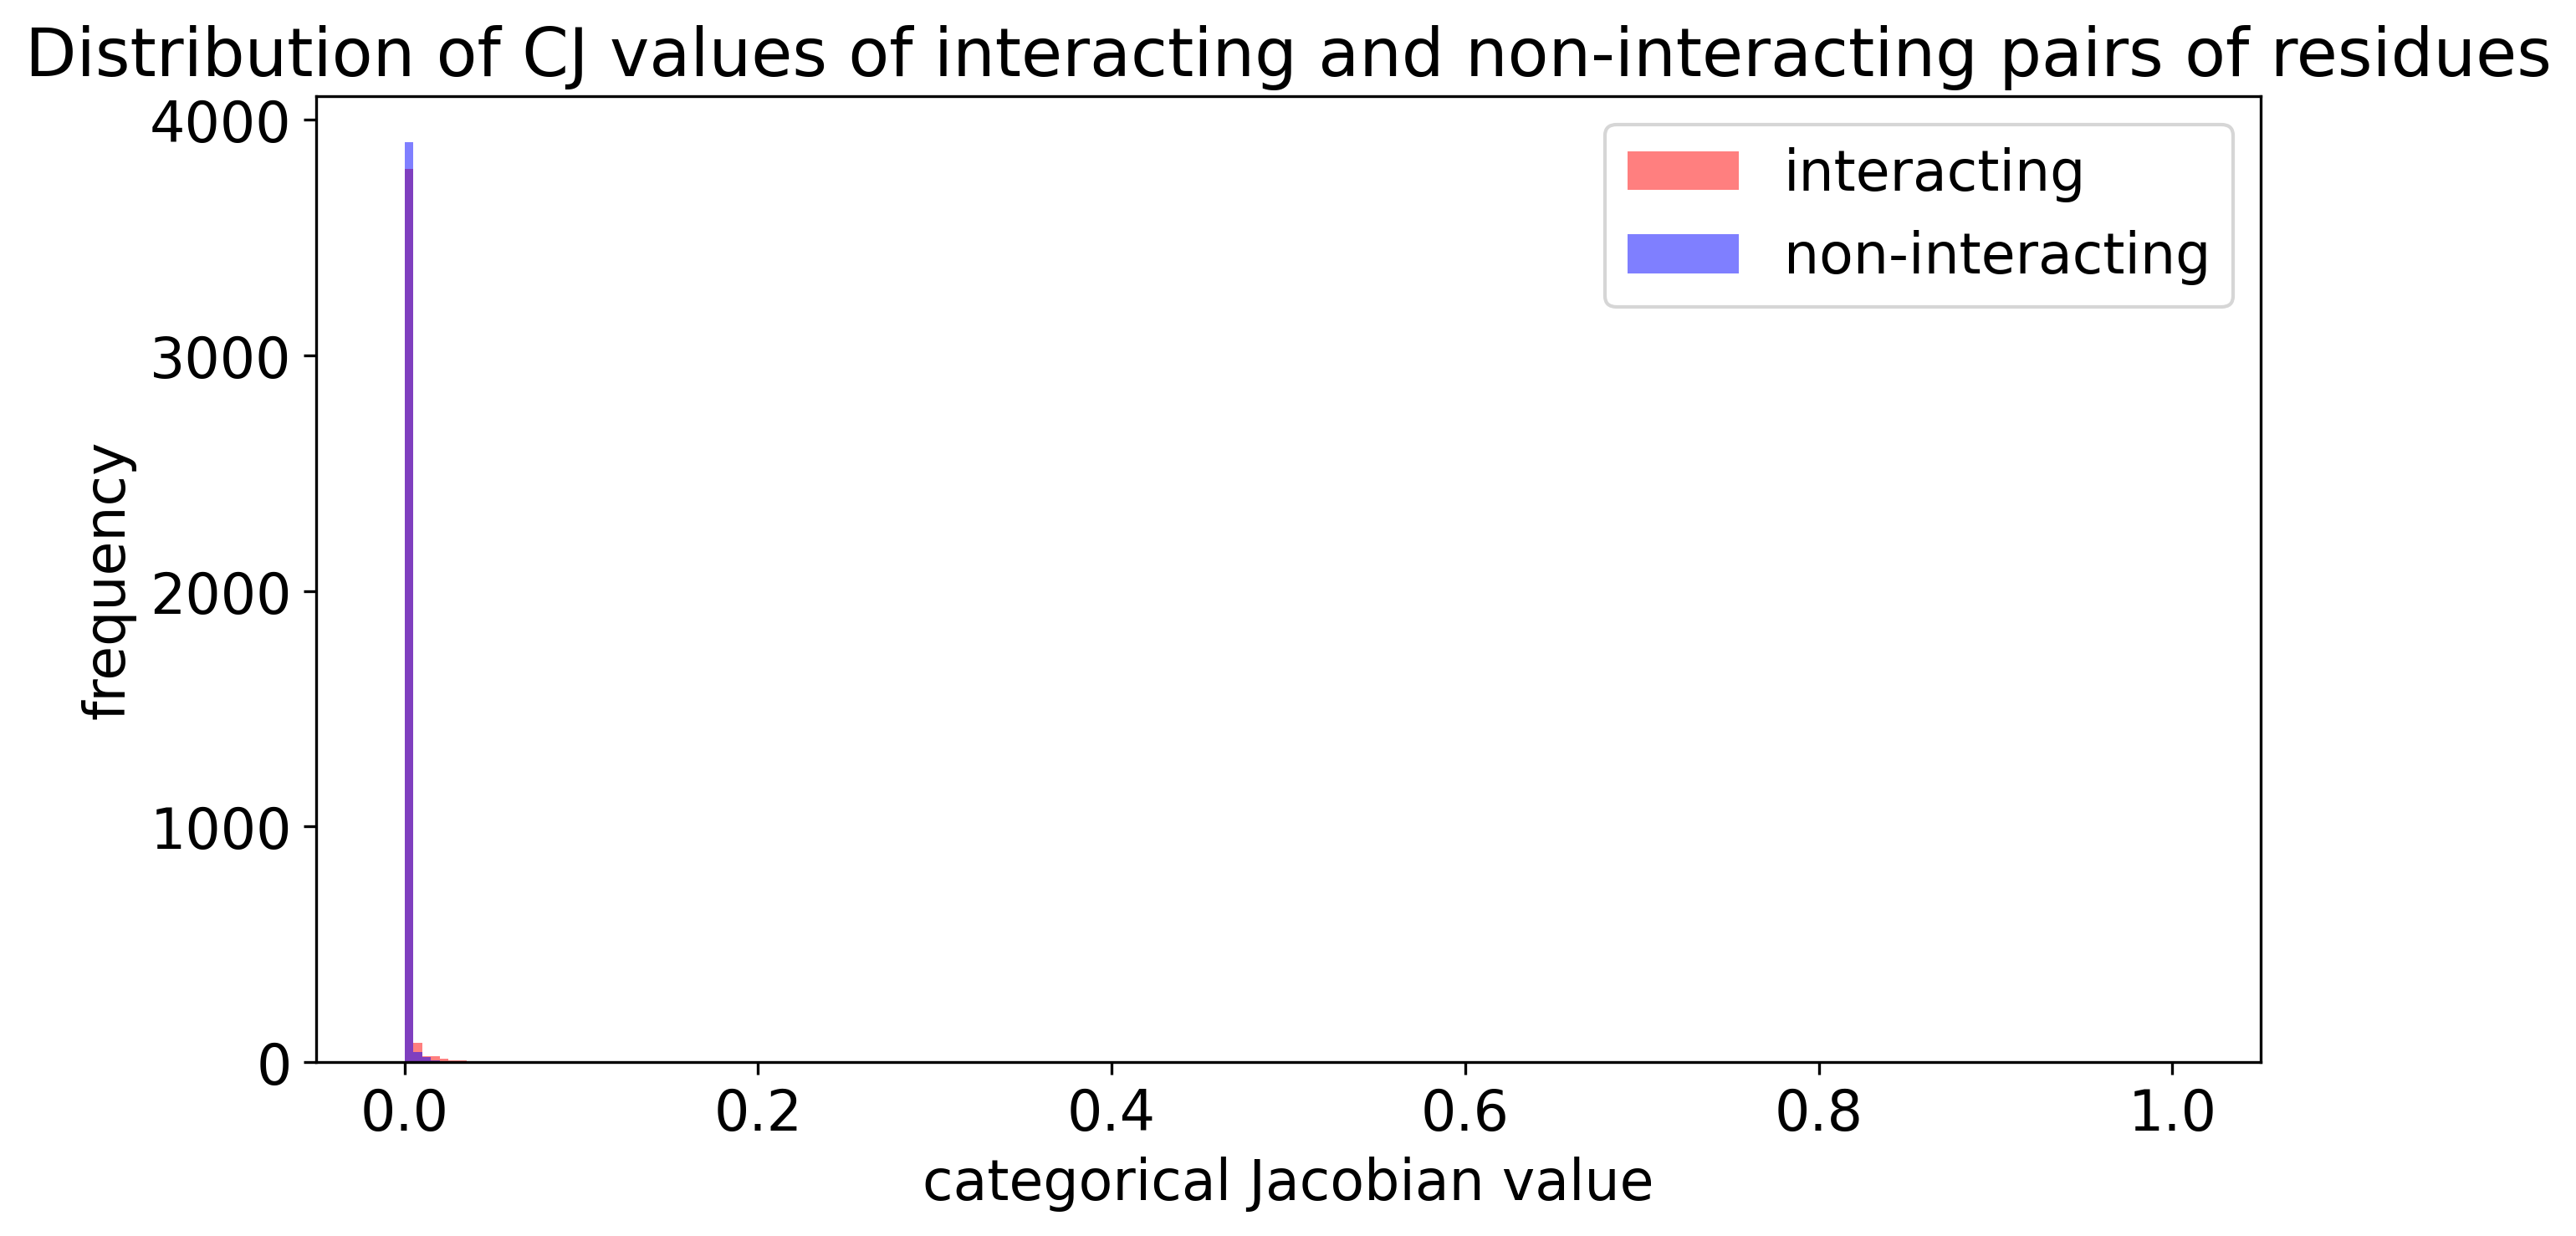

In [5]:
# Loading the categorical Jacobian
CJ_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/glm2_cosine_post250521/"

avg_metrics, dist_info = get_metrics_and_distances(data, CJ_PATH, get_distances=True, n=2)
present_metrics(avg_metrics)
plot_distance_distribution(dist_info)

_, signal_info = get_metrics_and_distances(data, CJ_PATH, get_distances=False)
plot_signal_distribution(signal_info, step=0.005)

MCC:  0.02265071685262591
Precision:  0.01731355072668673
Recall:  0.04271410682135392
Specificity:  0.9960921424436951
Balanced accuracy:  0.5194031246325246
Average percentage of outliers within contact map:  0.01731355072668673
Correlation between distances and CJ:  0.0008673228146417515
Average corr. coeff. for negative corr. coeff:  -0.022106210684739412
Average corr. coeff. for positive corr. coeff:  0.018558172140368423


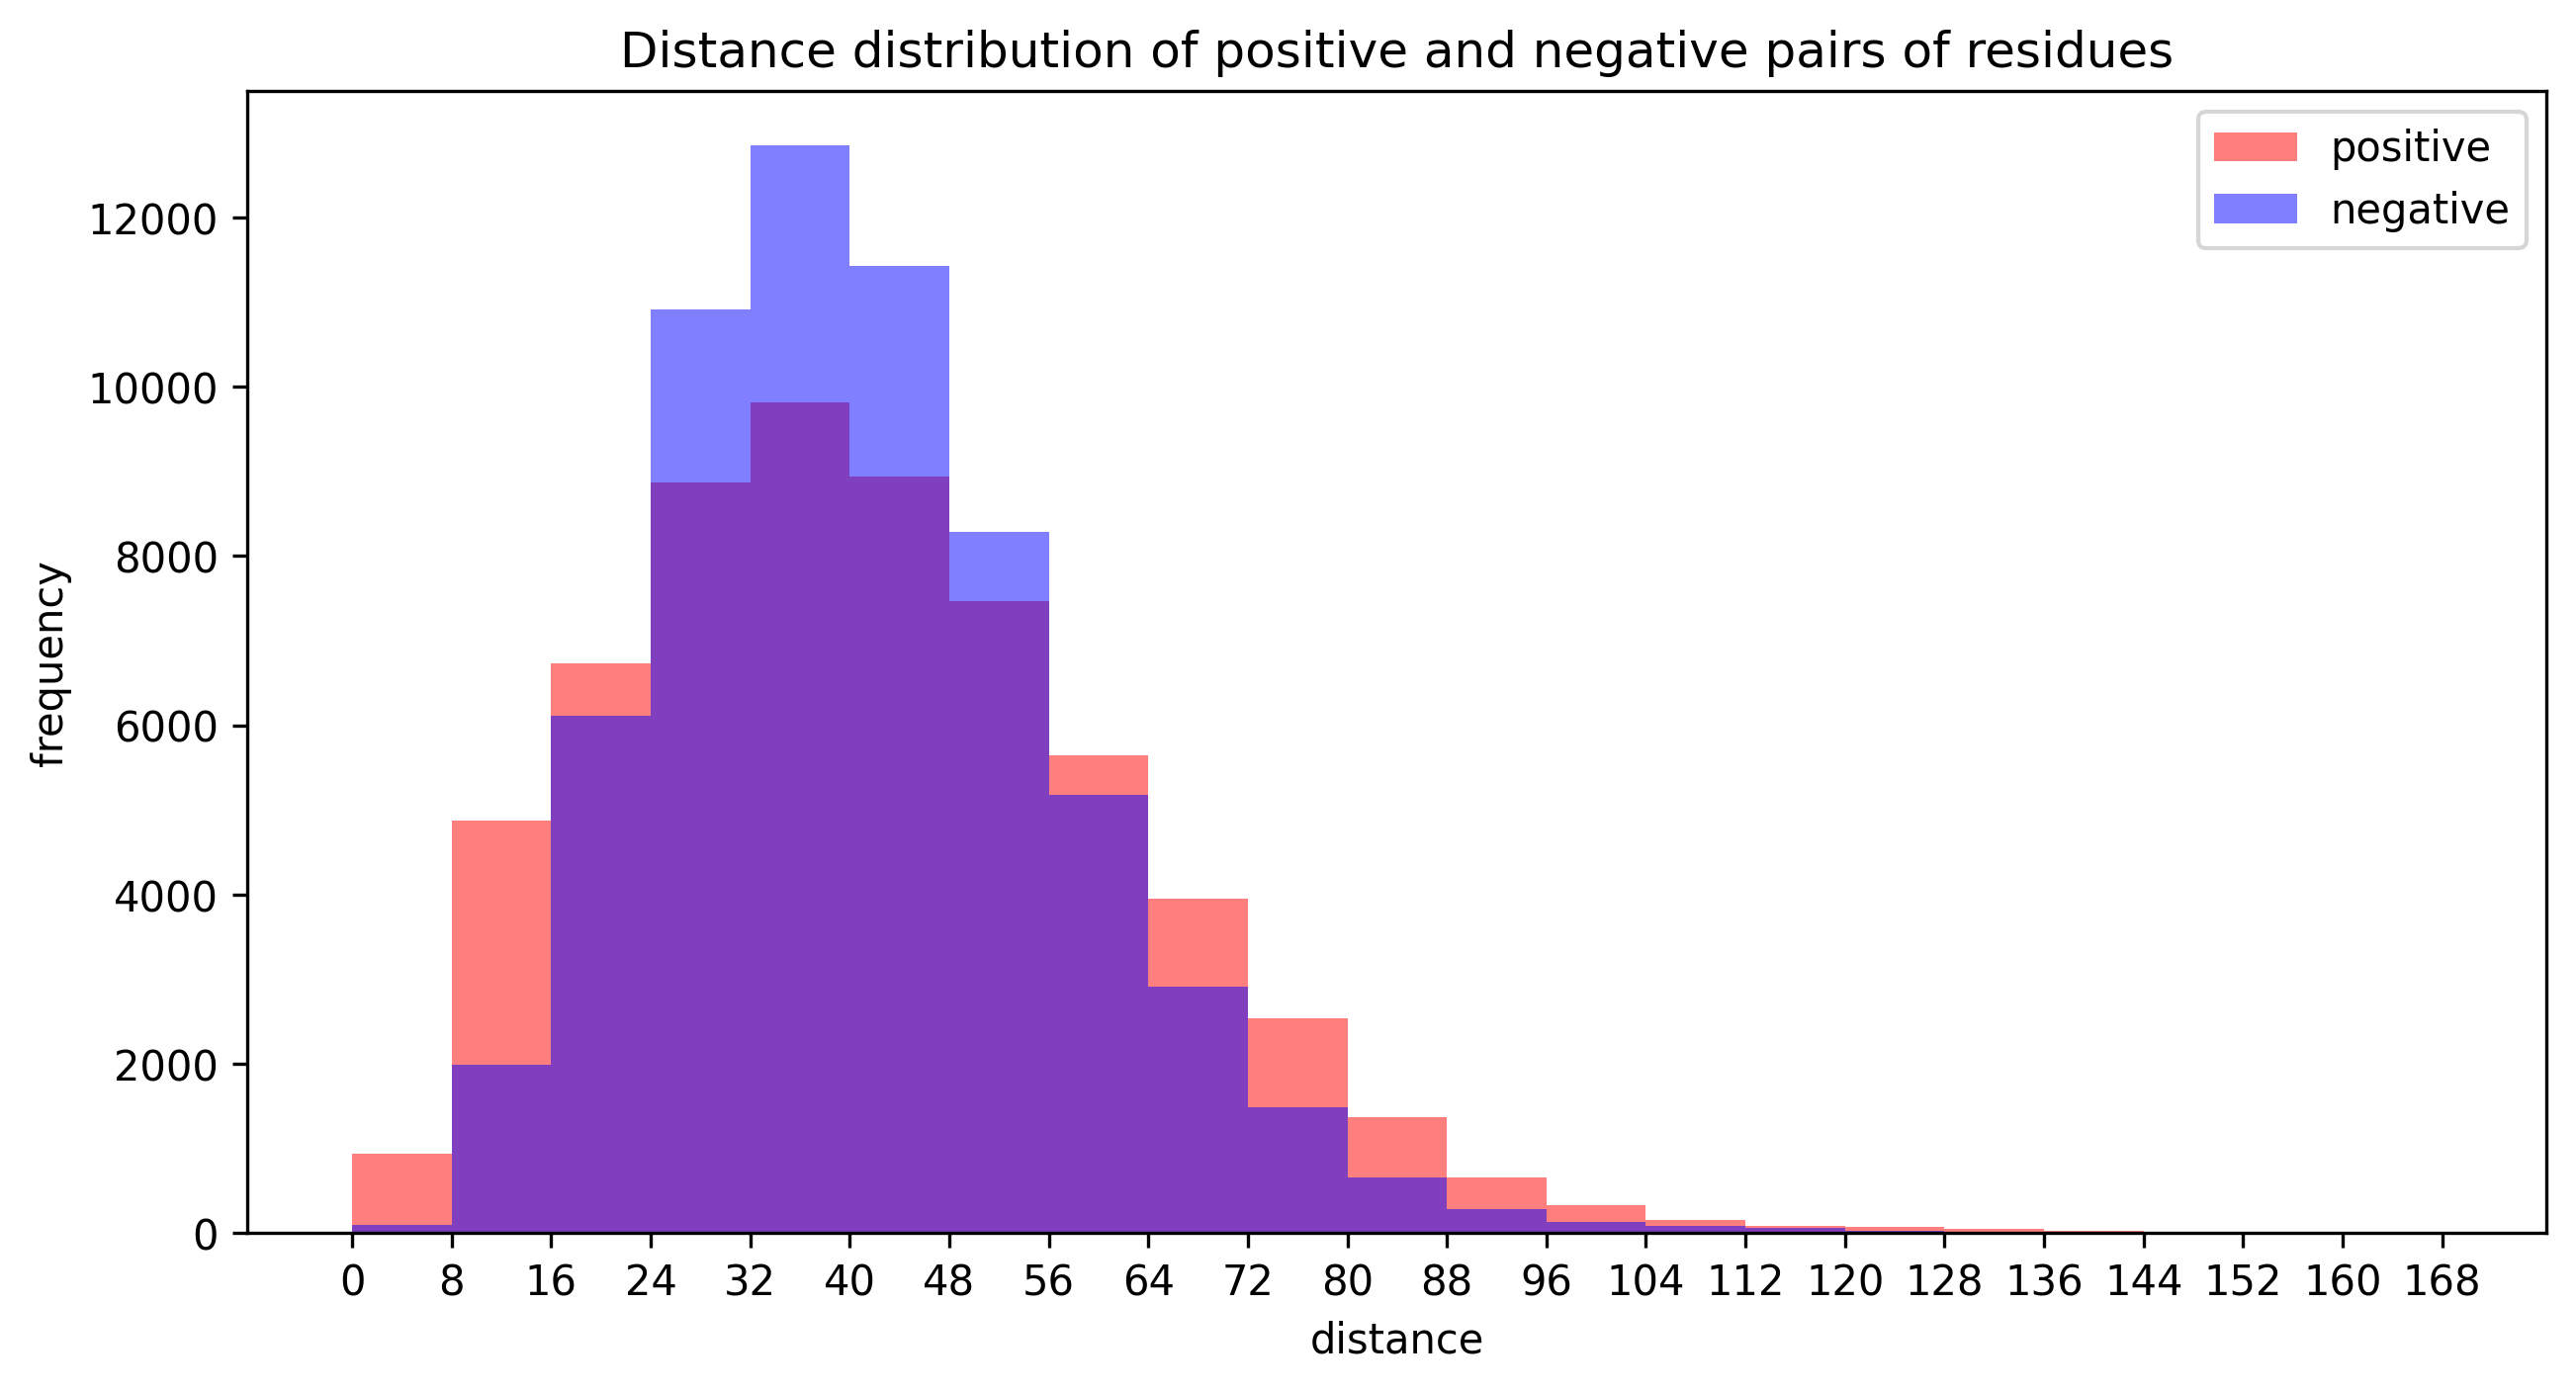

In [11]:
# Loading the categorical Jacobian
CJ_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/mint_cosine/"

avg_metrics, dist_info = get_metrics(data, CJ_PATH, biolm="mint")
present_metrics(avg_metrics)
plot_distance_distribution(dist_info)

52

In [24]:
SPLITS_DIR="/scicore/home/schwede/pudziu0000/projects/gLM/data/PINDER/eubacteria_5_1024_512_species_heterodimers/"
URQS_CM_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/urqs/contact_maps/"
BIOLM="glm2"

CJ_PATH=f"/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/{BIOLM}_cosine/"
URQS_CJ_PATH=f"/scicore/home/schwede/pudziu0000/projects/gLM/outputs/urqs/{BIOLM}_cosine/"

data = get_atom_data("test")
print(f"Number of data points: {len(data)}")

os.makedirs(URQS_CJ_PATH, exist_ok=True)
os.makedirs(URQS_CM_PATH, exist_ok=True)

for i in range(len(data)):
    contact_map = get_contact_map(data[i], padding=None)
    cj_contact_map, cj = get_cj_map(data[i], CJ_PATH, n=3, padding=None, biolm="glm2")
    complex_id = data[i]['id'].translate(str.maketrans({'_': '-', '-': '_'}))
    np.save(f"{URQS_CM_PATH}/{complex_id}.npy", contact_map)
    np.save(f"{URQS_CJ_PATH}/{complex_id}.npy", cj)
    

MCC:  0.0028001124522551947
Precision:  0.00787149649787981
Recall:  0.003690171453393079
Specificity:  0.9987474782862412
Balanced accuracy:  0.5012188248698171
Average percentage of outliers within contact map:  0.00787149649787981
Correlation between distances and CJ:  -0.0002071639702072997
Average corr. coeff. for negative corr. coeff:  -0.032970645582477545
Average corr. coeff. for positive corr. coeff:  0.02787582026888148


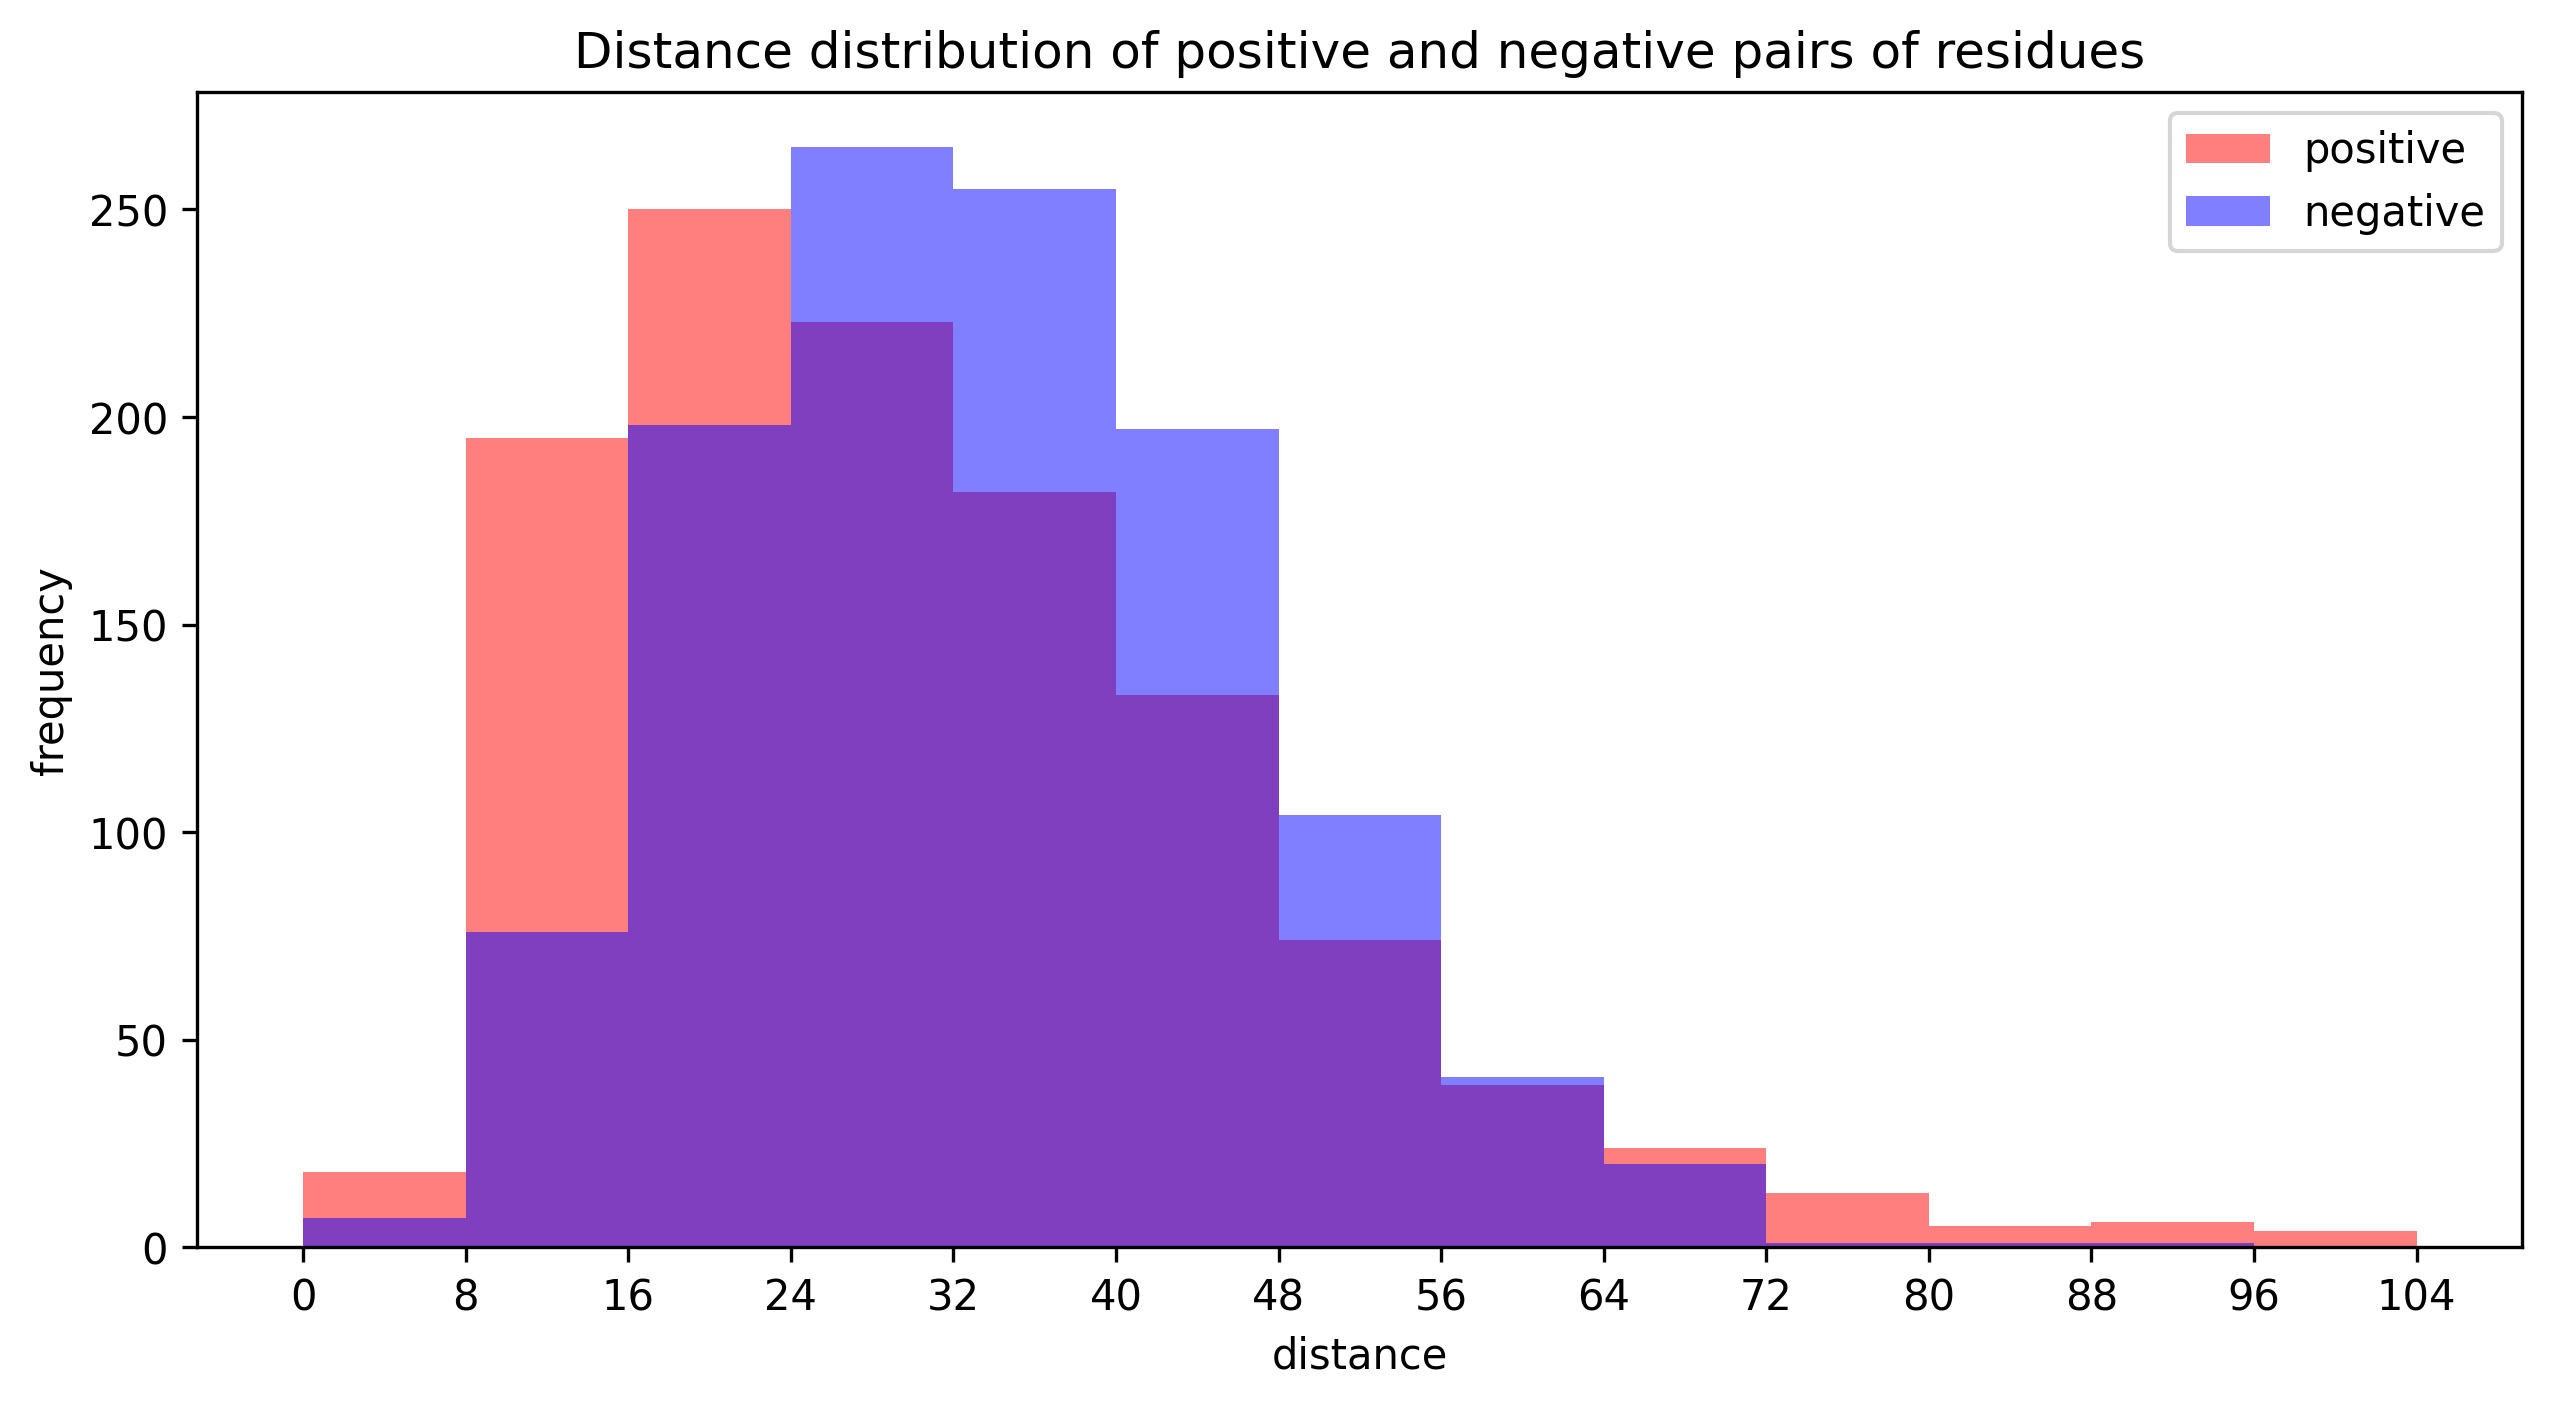

In [13]:
# Loading the categorical Jacobian
CJ_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/glm2_cosine/"

avg_metrics, dist_info = get_metrics(data, CJ_PATH)
present_metrics(avg_metrics)
plot_distance_distribution(dist_info)

MCC:  0.0066942298827506646
Precision:  0.00931200925404624
Recall:  0.008274798187954098
Specificity:  0.9985401795529116
Balanced accuracy:  0.503407488870433
Average percentage of outliers within contact map:  0.00931200925404624
Correlation between distances and CJ:  -0.0013306565211945122
Average corr. coeff. for negative corr. coeff:  -0.06183593535885803
Average corr. coeff. for positive corr. coeff:  0.08117654189380119


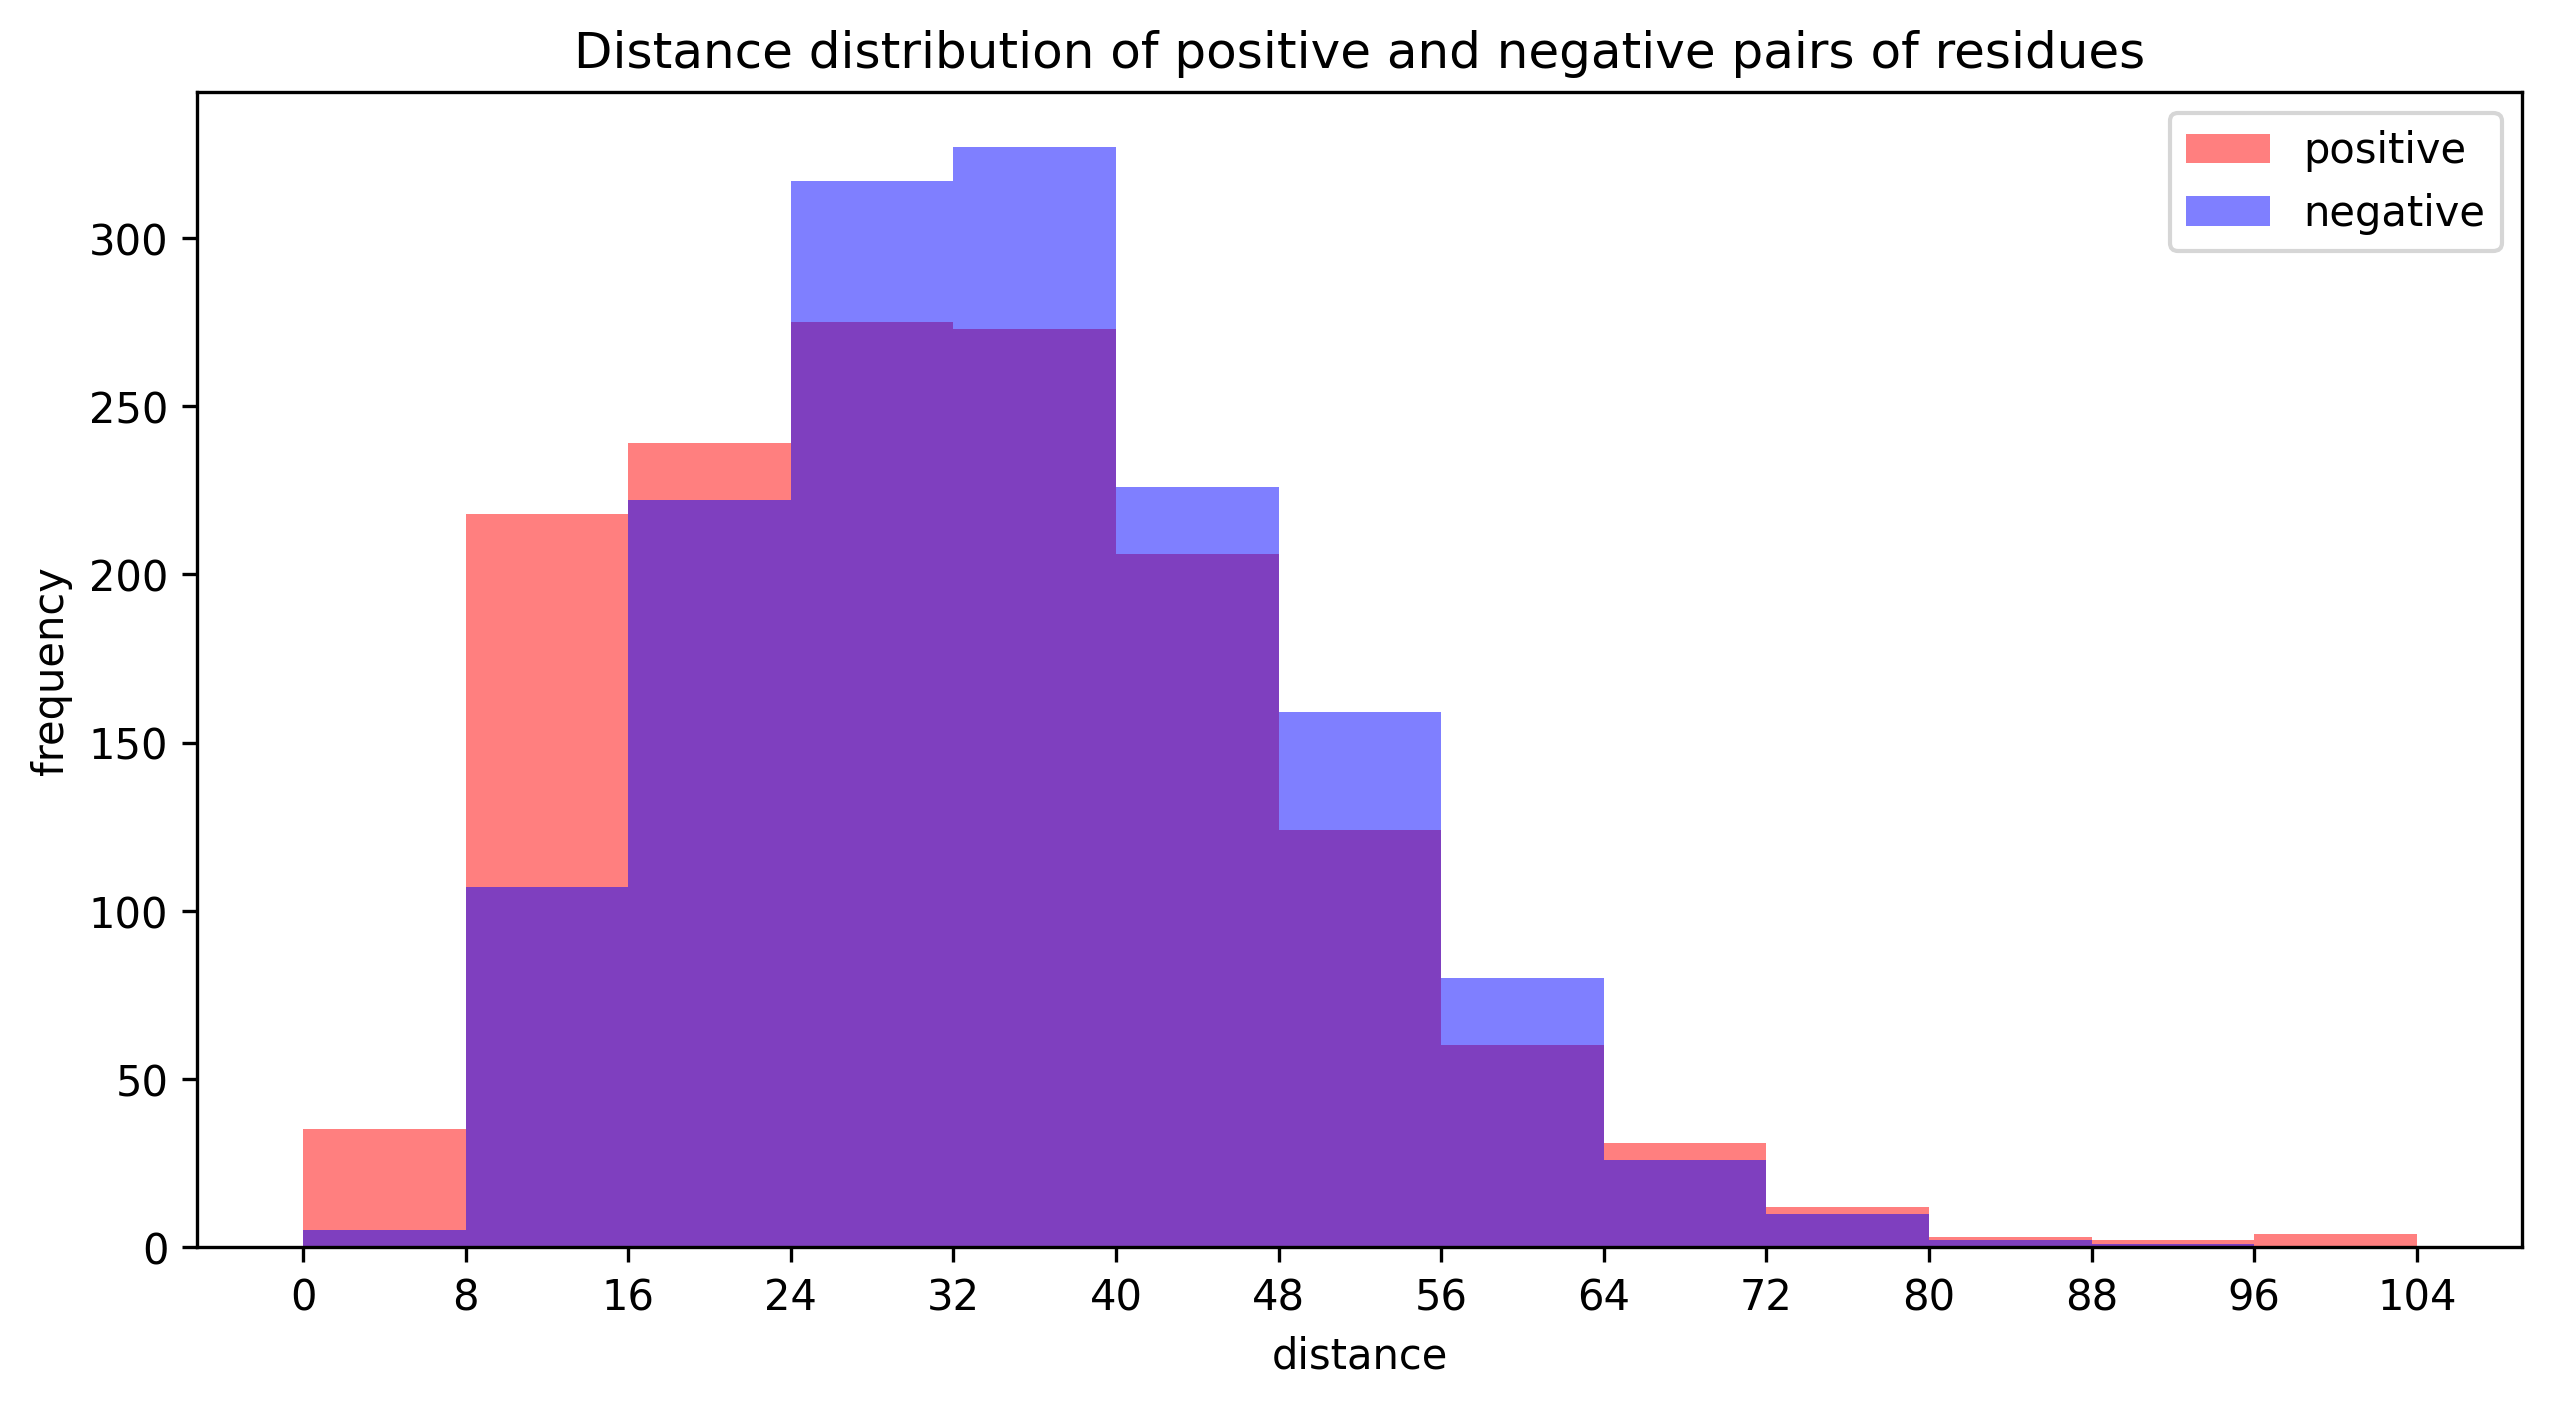

In [14]:
# Loading the categorical Jacobian
CJ_PATH="/scicore/home/schwede/pudziu0000/projects/gLM/outputs/categorical_jacobians/mint_cosine/"

avg_metrics, dist_info = get_metrics(data, CJ_PATH, biolm="mint")
present_metrics(avg_metrics)
plot_distance_distribution(dist_info)